In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import pandas as pd


In [ ]:
train_dir = '/content/drive/MyDrive/MSc_Thesis/osteoporosis_split/train'
validation_dir = '/content/drive/MyDrive/MSc_Thesis/osteoporosis_split/val'
test_dir = '/content/drive/MyDrive/MSc_Thesis/osteoporosis_split/test'
classes = ['normal', 'osteoporosis']


In [ ]:
def count_images(directory):
    class_counts = {}
    for class_name in classes:
        class_path = os.path.join(directory, class_name)
        class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

train_counts = count_images(train_dir)
validation_counts = count_images(validation_dir)
test_counts = count_images(test_dir)

print("Train:", train_counts)
print("Validation:", validation_counts)
print("Test:", test_counts)


Train: {'normal': 260, 'osteoporosis': 260}
Validation: {'normal': 75, 'osteoporosis': 75}
Test: {'normal': 37, 'osteoporosis': 37}


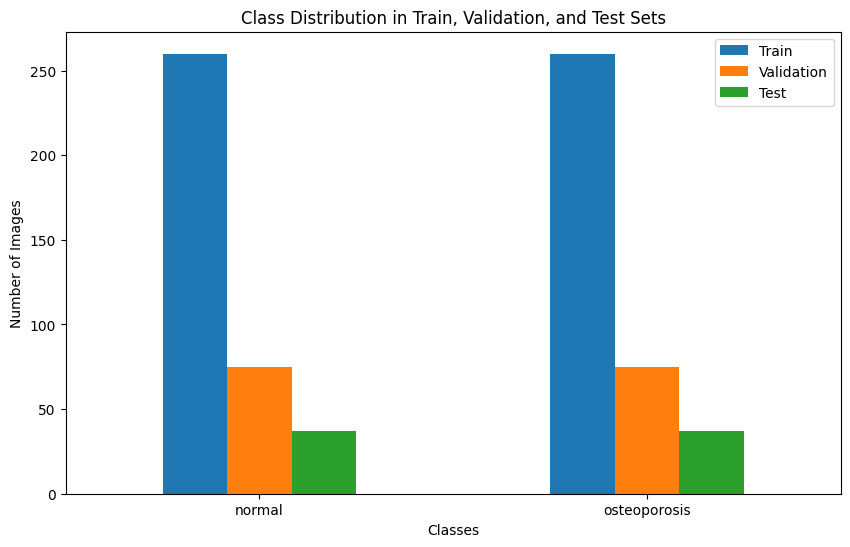

In [ ]:
# Combine counts into a DataFrame
data = {
    'Train': train_counts,
    'Validation': validation_counts,
    'Test': test_counts
}

df_counts = pd.DataFrame(data)

# Plot the class distribution
df_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Class Distribution in Train, Validation, and Test Sets')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=0)
plt.show()


In [ ]:
def get_image_sizes(directory):
    sizes = []
    for class_name in classes:
        class_path = os.path.join(directory, class_name)
        for image_name in os.listdir(class_path):
            img_path = os.path.join(class_path, image_name)
            img = Image.open(img_path)
            sizes.append(img.size)
    return sizes

train_sizes = get_image_sizes(train_dir)
validation_sizes = get_image_sizes(validation_dir)
test_sizes = get_image_sizes(test_dir)

# Convert sizes to DataFrame for analysis
df_sizes = pd.DataFrame(train_sizes, columns=['Width', 'Height'])
print(df_sizes.describe())


             Width       Height
count   520.000000   520.000000
mean    629.292308   956.125000
std     756.875345   909.492341
min     128.000000   256.000000
25%     128.000000   256.000000
50%     128.000000   256.000000
75%    1068.000000  1994.000000
max    2430.000000  2660.000000


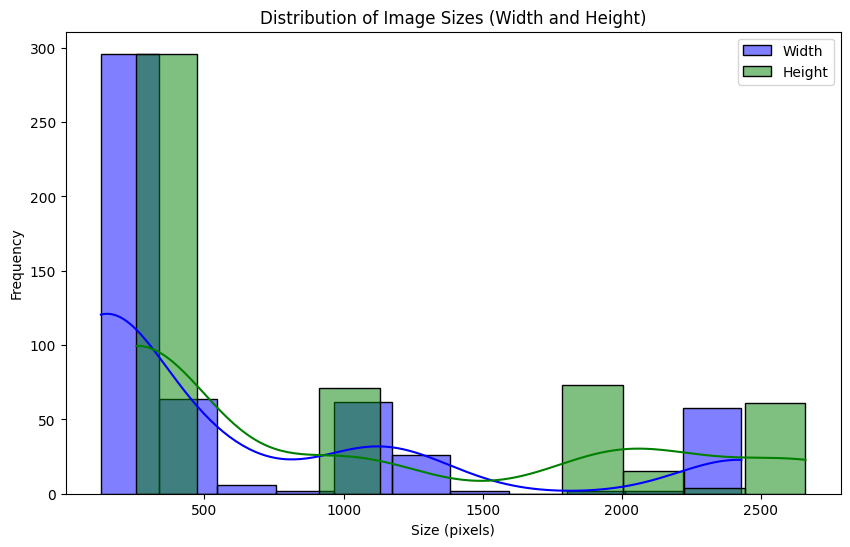

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_sizes['Width'], kde=True, label='Width', color='blue')
sns.histplot(df_sizes['Height'], kde=True, label='Height', color='green')
plt.title('Distribution of Image Sizes (Width and Height)')
plt.xlabel('Size (pixels)')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [ ]:
def get_image_sizes(directory):
    sizes = []
    for class_name in classes:
        class_path = os.path.join(directory, class_name)
        for image_name in os.listdir(class_path):
            img_path = os.path.join(class_path, image_name)
            img = Image.open(img_path)
            sizes.append(img.size)
    return sizes

train_sizes = get_image_sizes(train_dir)
validation_sizes = get_image_sizes(validation_dir)
test_sizes = get_image_sizes(test_dir)

# Convert sizes to DataFrame for analysis
df_train_sizes = pd.DataFrame(train_sizes, columns=['Width', 'Height'])
df_validation_sizes = pd.DataFrame(validation_sizes, columns=['Width', 'Height'])
df_test_sizes = pd.DataFrame(test_sizes, columns=['Width', 'Height'])


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from keras.applications import MobileNetV3Large
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from tensorflow.keras.applications.efficientnet import preprocess_input
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout # Import Dropout layer


# **MobileNet w/o XAI**

In [ ]:
#data directories
train_dir = '/content/drive/MyDrive/MSc_Thesis/osteoporosis_split/train'
val_dir = '/content/drive/MyDrive/MSc_Thesis/osteoporosis_split/val'
test_dir = '/content/drive/MyDrive/MSc_Thesis/osteoporosis_split/test'

In [ ]:
# Parameters
img_size = (224, 224)
batch_size = 32
num_classes = len(os.listdir(train_dir))

In [ ]:
# Data generators with augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical')

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical')

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 520 images belonging to 2 classes.
Found 150 images belonging to 2 classes.
Found 74 images belonging to 2 classes.


In [ ]:
# Load pre-trained EfficientNetB0 model
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

In [ ]:
# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create final model
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Freeze the layers of base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(train_generator, epochs=20, validation_data=val_generator)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.5459 - loss: 1.1662 - val_accuracy: 0.7800 - val_loss: 0.6027
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 25s 583ms/step - accuracy: 0.6860 - loss: 0.7759 - val_accuracy: 0.7667 - val_loss: 0.4961
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 622ms/step - accuracy: 0.6919 - loss: 0.6685 - val_accuracy: 0.8200 - val_loss: 0.4642
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 591ms/step - accuracy: 0.7628 - loss: 0.5209 - val_accuracy: 0.7200 - val_loss: 0.5367
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 591ms/step - accuracy: 0.7129 - loss: 0.6112 - val_accuracy: 0.8000 - val_loss: 0.4606
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 722ms/step - accuracy: 0.7143 - loss: 0.6669 - val_accuracy: 0.8067 - val_loss: 0.4493
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 623ms/step - accuracy: 0.7861 - loss: 0.4603 - val_accuracy: 0.7667 - val_loss: 0.4856
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 643ms/step - accuracy: 0.7472 - loss: 0.5327 - val_accuracy: 0.8000 -

In [ ]:
 Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.7250 - loss: 0.5482
Test Accuracy: 0.7702702879905701


In [ ]:
# Generate predictions
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score

# Make predictions on the test set
predictions = model.predict(test_generator)

# Convert probabilities to class labels (0 or 1)
predicted_classes = (predictions > 0.5).astype("int32").flatten()

# Get true labels
true_classes = test_generator.classes

# Compute confusion matrix
predicted_classes = np.argmax(predictions, axis=1)

conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Compute classification report
class_report = classification_report(true_classes, predicted_classes, target_names=['Class 0', 'Class 1'])

# Compute precision, recall, and F1 score
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)

# Print metrics
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 532ms/step
Confusion Matrix:
[[23 14]
 [ 3 34]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.88      0.62      0.73        37
     Class 1       0.71      0.92      0.80        37

    accuracy                           0.77        74
   macro avg       0.80      0.77      0.77        74
weighted avg       0.80      0.77      0.77        74

Precision: 0.7083333333333334
Recall: 0.918918918918919
F1 Score: 0.8000000000000002


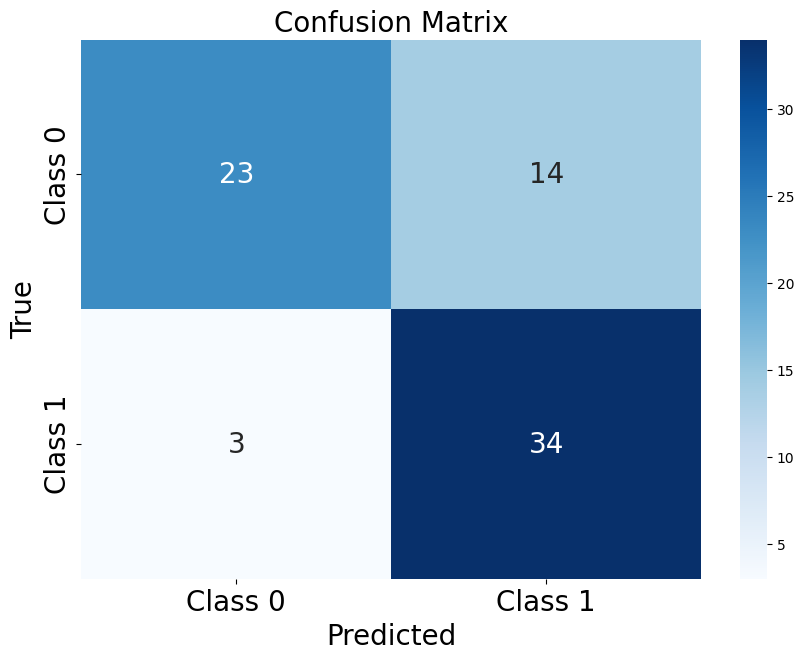

In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', ], yticklabels=['Class 0', 'Class 1'], annot_kws={"size": 20})
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('True', fontsize=20)
plt.title('Confusion Matrix', fontsize=20)


# Adjust the font size of x-tick and y-tick labels
plt.xticks(fontsize=20)  # x-tick labels
plt.yticks(fontsize=20)  # y-tick labels

plt.show()



In [ ]:
# Save the model
model.save("mobilenet_osteo.keras")


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
model = load_model("mobilenet_osteo.keras")


# ***Using LIME ***

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=8eb76ab183ed50c8155a93c0f00de59d92e3f1589ddf80d321e9300b68a94e94
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import lime
import lime.lime_image
import os
import keras
from keras.preprocessing import image
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [ ]:
from tensorflow.keras.models import load_model

# Load your pre-trained CNN model
model = load_model('mobilenet_osteo.keras')

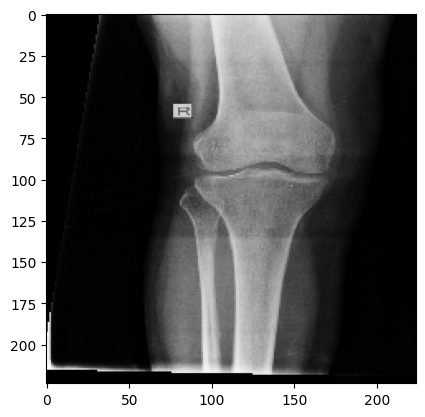

In [ ]:
img_path = (r"/content/drive/MyDrive/MSc_Thesis/osteoporosis_split/test/osteoporosis/119.jpg")

img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
img = image.img_to_array(img)# Transforming the image to get the shape as [channel, height, width]
img = np.expand_dims(img, axis=0) # Adding dimension to convert array into a batch of size (1,299,299,3)
img = img/255.0


In [ ]:
preds = model.predict(img)
print(preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[[0.35994986 0.6400501 ]]


In [ ]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
explainer = lime_image.LimeImageExplainer()

In [ ]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(img[0].astype('double'), model.predict, top_labels=4, hide_color=0, num_samples=500)


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

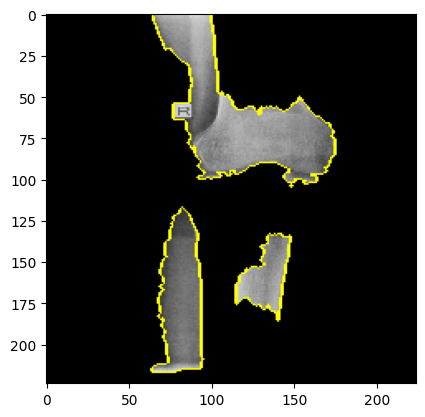

In [ ]:
from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp , mask))

Text(0.5, 1.0, '')

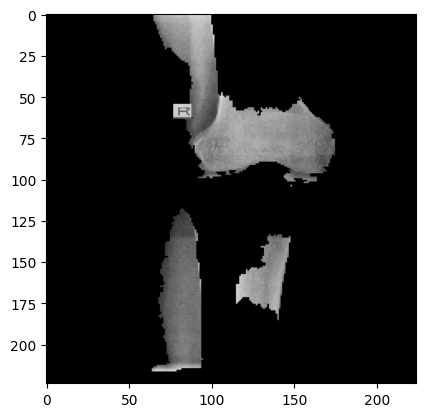

In [ ]:
plt.imshow(temp, cmap='gray')
plt.title('')

Text(0.5, 1.0, 'LIME Mask')

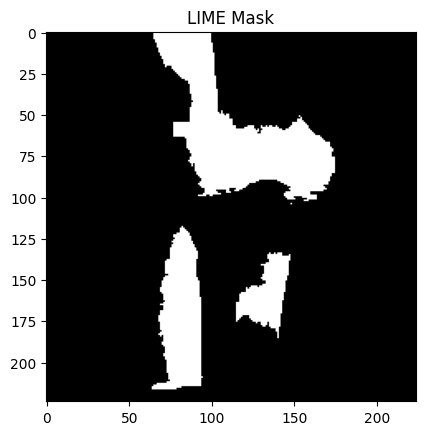

In [ ]:
plt.imshow(mask, cmap='gray')
plt.title('LIME Mask')

Text(0.5, 1.0, 'LIME Mask')

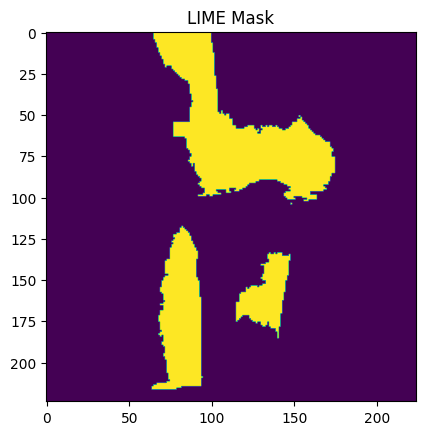

In [ ]:
plt.imshow(mask)
plt.title('LIME Mask')

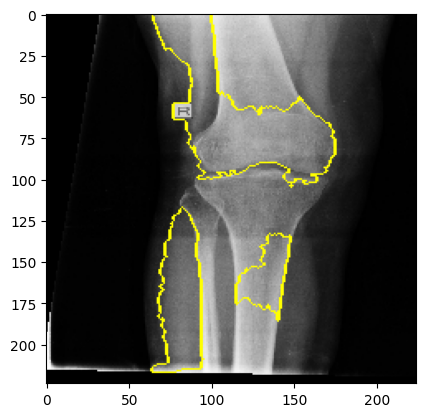

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))

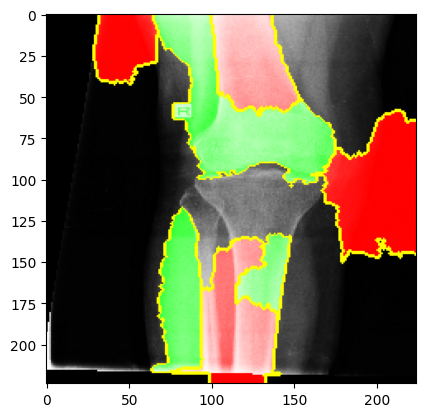

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))

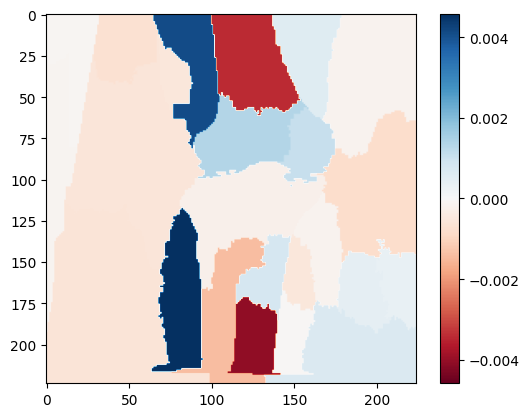

In [ ]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

# Feature Extraction with **LIME**

In [ ]:
import tensorflow as tf

# Load your trained EfficientNet model
mobilenet_model = tf.keras.models.load_model('mobilenet_osteo.h5')


In [ ]:
import numpy as np
import cv2
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Function to preprocess images for EfficientNet
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    return img_array

# Function to predict and return the probability of each class
def predict_fn(images):
    return mobilenet_model.predict(images)

# Function to apply LIME and get the explanation
def apply_lime(image_path, model):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(img_array[0], model.predict, top_labels=1, hide_color=0, num_samples=1000)

    # Get the image and mask for the top predicted class
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
    lime_img = mark_boundaries(temp / 2 + 0.5, mask)

    return lime_img, mask


In [ ]:
def extract_roi(image_path, mask):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    roi_img = img_array * np.expand_dims(mask, axis=-1)
    return roi_img.astype('uint8')

In [ ]:
import os
import shutil

def prepare_dataset(source_dir, dest_dir, model):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        dest_class_path = os.path.join(dest_dir, class_name)
        if not os.path.exists(dest_class_path):
            os.makedirs(dest_class_path)

        for img_name in os.listdir(class_path):
            image_path = os.path.join(class_path, img_name)
            lime_img, mask = apply_lime(image_path, model)
            roi_img = extract_roi(image_path, mask)
            roi_img_path = os.path.join(dest_class_path, img_name)
            cv2.imwrite(roi_img_path, roi_img)

# Create training, val, and test dataset from extracted feature
train_source_dir = '/content/drive/MyDrive/MSc_Thesis/osteoporosis_split/train'
train_dest_dir = '/content/drive/MyDrive/MSc_Thesis/mobilenet_new_osteo_ds/new_train'
prepare_dataset(train_source_dir, train_dest_dir, mobilenet_model)

val_source_dir = '/content/drive/MyDrive/MSc_Thesis/osteoporosis_split/val'
val_dest_dir = '/content/drive/MyDrive/MSc_Thesis/mobilenet_new_osteo_ds/new_val'
prepare_dataset(val_source_dir, val_dest_dir, mobilenet_model)

test_source_dir = '/content/drive/MyDrive/MSc_Thesis/osteoporosis_split/test'
test_dest_dir = '/content/drive/MyDrive/MSc_Thesis/mobilenet_new_osteo_ds/new_test'
prepare_dataset(test_source_dir, test_dest_dir, mobilenet_model)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


KeyboardInterrupt: 

# **Training Model with Extracted Feature Dataset**

In [ ]:
# Set new data directories
train_dir = '/content/drive/MyDrive/MSc_Thesis/osteoporosis_split/train'
val_dir = '/content/drive/MyDrive/MSc_Thesis/osteoporosis_split/val'
test_dir = '/content/drive/MyDrive/MSc_Thesis/osteoporosis_split/new_test'
img_size = (224, 224)
batch_size = 32

# Data generators with augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical')

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical')

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 520 images belonging to 2 classes.
Found 150 images belonging to 2 classes.
Found 74 images belonging to 2 classes.


In [ ]:
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))



# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, epochs=20, validation_data=val_generator)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.5383 - loss: 1.4735 - val_accuracy: 0.6933 - val_loss: 0.5414
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 522ms/step - accuracy: 0.6663 - loss: 0.7177 - val_accuracy: 0.7400 - val_loss: 0.4914
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 541ms/step - accuracy: 0.7077 - loss: 0.6074 - val_accuracy: 0.7933 - val_loss: 0.4890
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 567ms/step - accuracy: 0.7296 - loss: 0.5546 - val_accuracy: 0.7400 - val_loss: 0.5045
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 681ms/step - accuracy: 0.7061 - loss: 0.5821 - val_accuracy: 0.8067 - val_loss: 0.4719
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 575ms/step - accuracy: 0.7329 - loss: 0.5545 - val_accuracy: 0.7667 - val_loss: 0.4816
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 619ms/step - accuracy: 0.7612 - loss: 0.4915 - val_accuracy: 0.7867 - val_loss: 0.4671
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 664ms/step - accuracy: 0.7712 - loss: 0.5231 - val_accuracy: 0.7867 -

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)

3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.8895 - loss: 0.3460
Test Accuracy: 0.8648648858070374


In [ ]:
# Generate predictions
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Confusion Matrix:
[[35  2]
 [ 8 29]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.81      0.95      0.88        37
     Class 1       0.94      0.78      0.85        37

    accuracy                           0.86        74
   macro avg       0.87      0.86      0.86        74
weighted avg       0.87      0.86      0.86        74

Precision: 0.9354838709677419
Recall: 0.7837837837837838
F1 Score: 0.8529411764705881


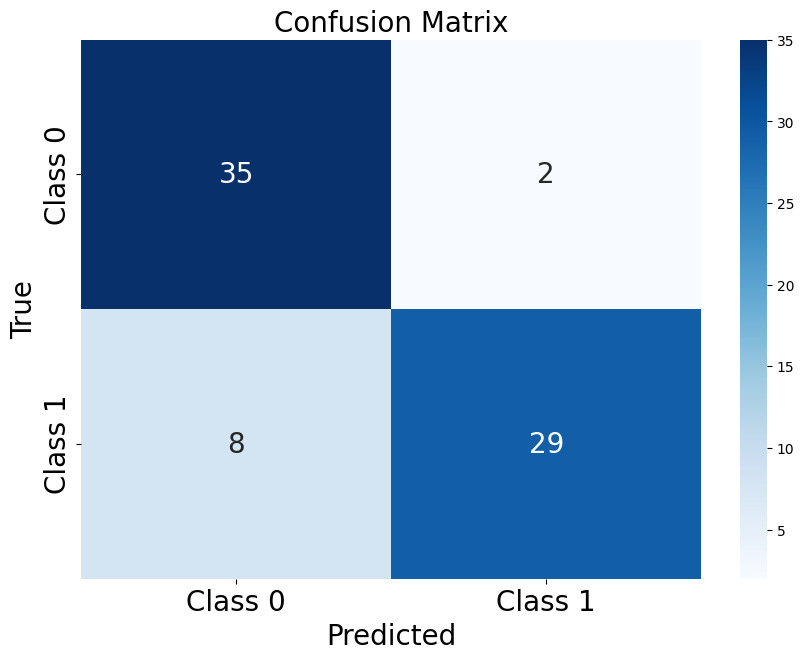

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score

# Make predictions on the test set
predictions = model.predict(test_generator)

# Convert probabilities to class labels (0 or 1)
predicted_classes = (predictions > 0.5).astype("int32").flatten()

# Get true labels
true_classes = test_generator.classes

# Compute confusion matrix
predicted_classes = np.argmax(predictions, axis=1)

conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Compute classification report
class_report = classification_report(true_classes, predicted_classes, target_names=['Class 0', 'Class 1'])

# Compute precision, recall, and F1 score
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)

# Print metrics
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


import seaborn as sns
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', ], yticklabels=['Class 0', 'Class 1'], annot_kws={"size": 20})
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('True', fontsize=20)
plt.title('Confusion Matrix', fontsize=20)


# Adjust the font size of x-tick and y-tick labels
plt.xticks(fontsize=20)  # x-tick labels
plt.yticks(fontsize=20)  # y-tick labels

plt.show()